<a href="https://colab.research.google.com/github/Nikhil5566/EDA-Repo/blob/main/MSc_Project_N1217583.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# for TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For Grad-CAM
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import matplotlib.cm as cm

# For Image Utilities
from PIL import Image
import glob

# Connecting Drive
from google.colab import drive
drive.mount('/content/drive')
from collections import defaultdict

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plantvillage_path = '/content/drive/MyDrive/Final Project Dataset/PlantVillage'

# Create a dictionary to hold all image paths by class
dataset = defaultdict(list)

for class_name in os.listdir(plantvillage_path):
    class_path = os.path.join(plantvillage_path, class_name)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                dataset[class_name].append(os.path.join(class_path, image_file))

# Print summary
for class_name, images in dataset.items():
    print(f"{class_name}: {len(images)} images")

Tomato__Tomato_mosaic_virus: 373 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Bacterial_spot: 2127 images
Tomato_healthy: 1591 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato_Early_blight: 1000 images
Potato___healthy: 152 images
Potato___Late_blight: 1000 images
Pepper__bell___healthy: 1478 images
Pepper__bell___Bacterial_spot: 993 images
Potato___Early_blight: 1000 images


In [ ]:
# List all files in the folder
files = os.listdir('/content/drive/MyDrive/Final Project Dataset/PlantVillage/Tomato__Tomato_mosaic_virus')
print(f"Found {len(files)} files in {'/content/drive/MyDrive/Final Project Dataset/PlantVillage/Tomato__Tomato_mosaic_virus'}")

Found 373 files in /content/drive/MyDrive/Final Project Dataset/PlantVillage/Tomato__Tomato_mosaic_virus


#  1. Visualize Some Sample Images

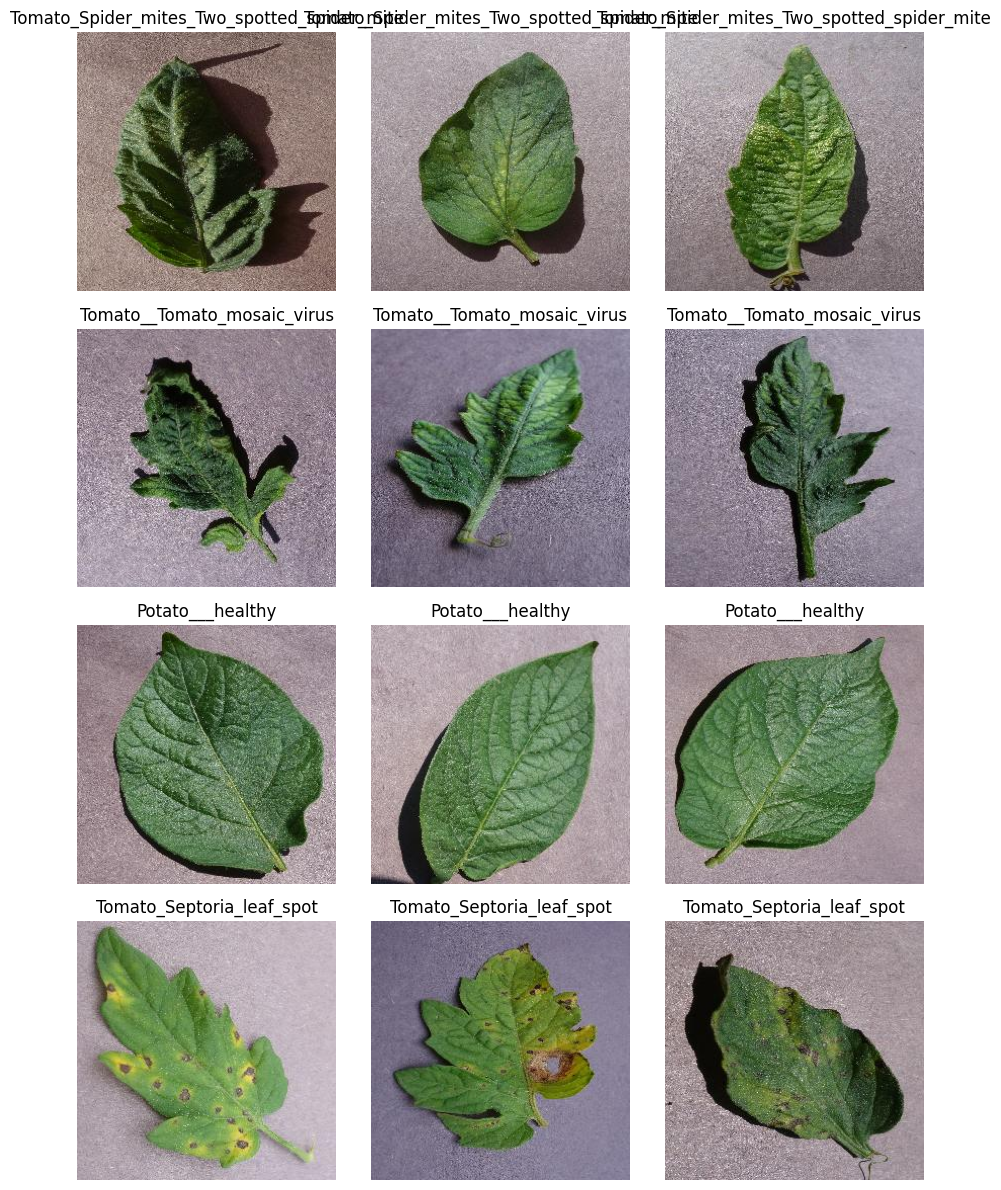

In [ ]:
import matplotlib.pyplot as plt
import random

# Display sample images from random classes
def show_sample_images(dataset, num_classes=4, samples_per_class=3):
    class_names = list(dataset.keys())
    random.shuffle(class_names)
    selected_classes = class_names[:num_classes]

    plt.figure(figsize=(samples_per_class * 3, num_classes * 3))

    for i, class_name in enumerate(selected_classes):
        images = dataset[class_name]
        random.shuffle(images)
        for j in range(samples_per_class):
            img = cv2.imread(images[j])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_sample_images(dataset)

# 2. Prepare Image Paths for Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

for class_name, files in dataset.items():
    for file in files:
        image_paths.append(file)
        labels.append(class_name)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
)

print(f"Train samples: {len(X_train)} | Validation samples: {len(X_val)}")


Train samples: 16507 | Validation samples: 4127


# 3. Use ImageDataGenerator for Augmentation

In [ ]:
# Section 3 itself doesn't produce a visible output in the form of a printed message or a plot.
# However, it performs crucial setup steps that are essential for the following sections of your code,
# particularly for handling and augmenting your image data.

# Here's what Section 3 does:

'''Imports necessary library:
It imports ImageDataGenerator from tensorflow.keras.preprocessing.image. This class is a powerful tool for augmenting image data on the fly.
Defines parameters: It defines two important parameters:

IMG_SIZE:
This sets the target size to which all images will be resized (224x224 pixels in your case). Consistent image size is required for training a CNN.
BATCH_SIZE: This determines the number of images that will be processed together in each batch during training.

Creates ImageDataGenerator instances: It creates two ImageDataGenerator objects:
1. train_datagen: This is configured with various data augmentation techniques such as rotation, shifting, zooming, and horizontal flipping. Data augmentation helps to increase the size and diversity of your training dataset, which can improve the model's generalization ability and reduce overfitting. It also includes rescale=1./255 to normalize pixel values to the range [0, 1], which is a common practice for neural networks.
2. val_datagen: This is configured only with rescale=1./255. Data augmentation is typically applied only to the training data, not the validation or test data, to ensure that the evaluation metrics are based on the original, unaltered images.
Defines a helper function (though not used directly in subsequent sections as written): It defines a function path_to_tensor. While this function is defined, the following sections use a different approach (tf.data.Dataset) for processing images, so this specific function isn't actively used in your current code flow. However, its presence suggests an alternative way you could have approached image loading if you were using the flow_from_directory method of ImageDataGenerator.

In summary, Section 3 sets up the tools (ImageDataGenerator) and parameters for image preprocessing and data augmentation, which are vital steps before feeding the images into your neural network model for training. Although it doesn't produce direct output, it lays the groundwork for the data loading and processing that happen in Section 4.'''

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Helper function to load data from paths
def path_to_tensor(image_path, label):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img, label


# 4. Create TensorFlow Dataset from Paths

In [ ]:
import tensorflow as tf

# Create a TensorFlow Dataset object from image paths and labels
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label

# Wrap in tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_ds = train_ds.map(process_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(process_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 5. Build CNN Model (EfficientNetB0-based)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Define model
def build_model(num_classes):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model(num_classes=len(le.classes_))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,068,786 (15.52 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 6. Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.1321 - loss: 2.6155 

516/516 ━━━━━━━━━━━━━━━━━━━━ 7671s 14s/step - accuracy: 0.1322 - loss: 2.6155 - val_accuracy: 0.1556 - val_loss: 2.5814
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1666s 3s/step - accuracy: 0.1369 - loss: 2.6042 - val_accuracy: 0.1556 - val_loss: 2.5821
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1726s 3s/step - accuracy: 0.1355 - loss: 2.6072 - val_accuracy: 0.1030 - val_loss: 2.5961
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1667s 3s/step - accuracy: 0.1382 - loss: 2.5969 - val_accuracy: 0.1556 - val_loss: 2.5770
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1508s 3s/step - accuracy: 0.1416 - loss: 2.5990 - val_accuracy: 0.1556 - val_loss: 2.5715
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1562s 3s/step - accuracy: 0.1423 - loss: 2.5989 - val_accuracy: 0.1556 - val_loss: 2.5796
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1696s 3s/step - accuracy: 0.1399 - loss: 2.6022 - val_accuracy: 0.1556 - val_loss: 2.5803
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 1539s 3s/step - accuracy: 0.1448 - loss: 2.5946 - val_accura

# 7. Plot Accuracy & Loss Curves

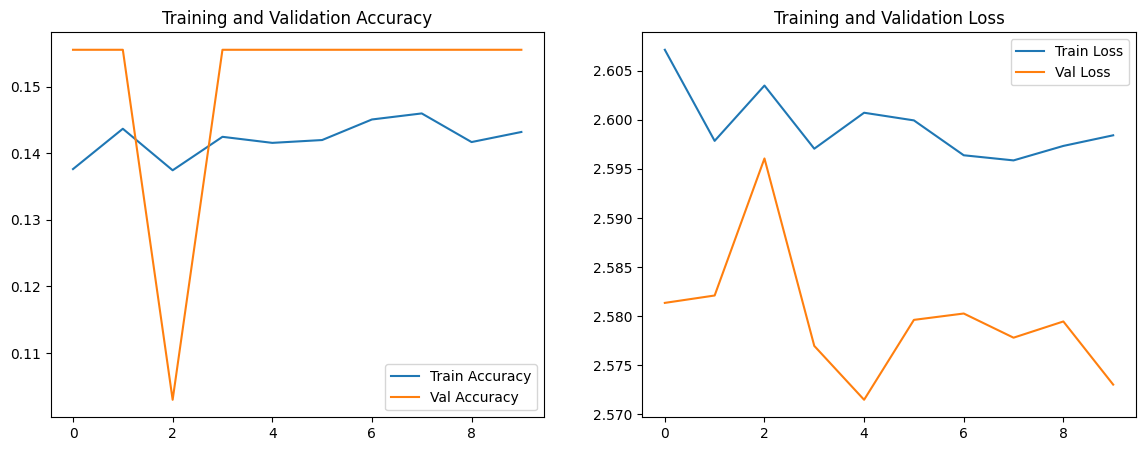

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training(history)